# CHECK THE TODOS
## Confronto modelli KNN su dataset Empty, Crowded e Hybrid
### 1. Import delle librerie e caricamento dei dati

In [56]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
# Importing dataset
file_path_bin = "../../data/processed/wifi_fingerprinting_dataset_binarized.csv"
file_path_norm = "../../data/processed/wifi_fingerprinting_dataset_normalized.csv"
file_path_0 = "../../data/raw//wifi_fingerprinting_dataset.csv"
file_path_200 = "../../data/raw/wifi_fingerprinting_dataset_cut_200_ap27.csv"
file_path_400 = "../../data/processed/wifi_fingerprinting_dataset_cut_400_ap22.csv"


df = pd.read_csv(file_path_bin, sep=',')

# Filling NaN values with -200 RSSI: AP is too far away from the current reference point and no signals could be heard from it
# With dataset_binarized and dataset_normalized all RSSI are already filled
# and no values will be added
df.fillna(-200, inplace=True)

# Creating different dataframes based on room situation: empty, crowded and hybrid (a mix of the two)
# For each dataframe "Situazione" column is dropped
df_empty = df[df["Situazione"] == "Empty"].drop(columns=["Situazione"])
df_crowded = df[df["Situazione"] == "Crowded"].drop(columns=["Situazione"])
df_hybrid = df.drop(columns=["Situazione"])

### 2. Creazione dei modelli

In [58]:
# Split the data into training and test sets
# 70% training set, 30% test set
def split_data(df):
    X = df.drop(columns=["Aula"])
    y = df["Aula"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    return X_train, X_test, y_train, y_test

X_train_empty, X_test_empty, y_train_empty, y_test_empty = split_data(df_empty)
X_train_crowded, X_test_crowded, y_train_crowded, y_test_crowded = split_data(df_crowded)
X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = split_data(df_hybrid)

# Display the number of samples in each split for all datasets
def print_split_info(name, X_train, X_test):
    print(f"\n{name} dataset:")
    print(f"  Train set:      {X_train.shape[0]} samples")
    print(f"  Test set:       {X_test.shape[0]} samples")

print_split_info("Empty", X_train_empty, X_test_empty)
print_split_info("Crowded", X_train_crowded, X_test_crowded)
print_split_info("Hybrid", X_train_hybrid, X_test_hybrid)


Empty dataset:
  Train set:      338 samples
  Test set:       146 samples

Crowded dataset:
  Train set:      349 samples
  Test set:       150 samples

Hybrid dataset:
  Train set:      688 samples
  Test set:       295 samples


### 3. Addestramento dei modelli

In [59]:
# TODO CHECH HERE
# Grid Search with Cross-Validation
# Parameters tuning for empty, crowded and hybrid situations is calculated by GridSearchCV
# GridSearchCV iterates on all different parameters given and elaborate wich one give the best results based on a certain metric
    # we want the best accuracy
# This "elaboration" is enhanced by cross-validation mechanism (multiple "validation" sets)
    # we keep the validation sets stratified
    # we split in 4 folds, to simulate the classic 70% training set (17,5% validation sets overall), 30% test set

# KNeighborsClassifier parameters:
# n_neighbors: the "k" in KNN   -->  low k prone to overfitting, high k prone to underfitting
# weights
    # uniform: each point has the same importance
    # distance: closer neighbors have a greater influence to the one further away
# metric: distance computation
# p: Power parameter for the Minkowski metric
    # metric not very used, p can be left default



# n_jobs: parallel jobs to run
    # -1 means all the processors



def find_best_knn(X_train, y_train):
    param_grid = {
        'n_neighbors': range(1, 21),
        'weights': ['uniform', 'distance'], #,
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        # leaf_size
        'metric': ['euclidean', 'manhattan', 'minkowski'],
        #'p': [1, 2]        #TODO NECESSARY?
    }

    knn = KNeighborsClassifier()

    # StratifiedKFold: splits data into k folds, but ensures each fold has the same distribution of class labels

    #TODO ACCURACY BEST SCORING METHOD?
    grid_search = GridSearchCV(knn, param_grid, cv=StratifiedKFold(n_splits=4), scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train) ## TODO really necessary?

    return grid_search.best_params_, grid_search.best_score_

best_params_empty, acc_empty = find_best_knn(X_train_empty, y_train_empty)
best_params_crowded, acc_crowded = find_best_knn(X_train_crowded, y_train_crowded)
best_params_hybrid, acc_hybrid = find_best_knn(X_train_hybrid, y_train_hybrid)

print(f"Empty -> Best params: {best_params_empty}, Best accuracy: {acc_empty:.4f}")
print(f"Crowded -> Best params: {best_params_crowded}, Best accuracy: {acc_crowded:.4f}")
print(f"Hybrid -> Best params: {best_params_hybrid}, Best accuracy: {acc_hybrid:.4f}")

Empty -> Best params: {'algorithm': 'brute', 'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}, Best accuracy: 0.9793
Crowded -> Best params: {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}, Best accuracy: 0.9340
Hybrid -> Best params: {'algorithm': 'brute', 'metric': 'euclidean', 'n_neighbors': 16, 'weights': 'uniform'}, Best accuracy: 0.9302


### 5. Risultati

In [60]:
# Function to evaluate the model on the test set and display summary metrics
def evaluate_on_test_summary(X_train, y_train, X_test, y_test, best_params, label, label2):
    # Use the best parameters found during grid search
    model = KNeighborsClassifier(**best_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    type_dict = {
        "Train Model": label,
        "Test Model": label2,
        "Metric": best_params['metric'],
        "Neighbors": best_params['n_neighbors'],
        #"p": best_params['p'],
        "Weights": best_params['weights']
    }

    metric_dict = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    }

    return type_dict, metric_dict



em = "Empty"
cr = "Crowded"
hy = "Hybrid"

# Evaluate on the test set with the best parameters for each dataset
results = []
results.append(evaluate_on_test_summary(X_train_empty, y_train_empty, X_test_empty, y_test_empty, best_params_empty, em, em))
results.append(evaluate_on_test_summary(X_train_crowded, y_train_crowded, X_test_crowded, y_test_crowded, best_params_crowded, cr, cr))
results.append(evaluate_on_test_summary(X_train_hybrid, y_train_hybrid, X_test_hybrid, y_test_hybrid, best_params_hybrid, hy, hy))

# Cross testing: we want to evaluate the quality of the model by testing a certain situation on a model trained on a different situation
#
#
#

results.append(evaluate_on_test_summary(X_train_empty, y_train_empty, X_test_crowded, y_test_crowded, best_params_empty, em, cr))
results.append(evaluate_on_test_summary(X_train_crowded, y_train_crowded, X_test_empty, y_test_empty, best_params_crowded, cr, em))
results.append(evaluate_on_test_summary(X_train_hybrid, y_train_hybrid, X_test_empty, y_test_empty, best_params_hybrid, hy, em))
results.append(evaluate_on_test_summary(X_train_hybrid, y_train_hybrid, X_test_crowded, y_test_crowded, best_params_hybrid, hy, cr))
results.append(evaluate_on_test_summary(X_train_empty, y_train_empty, X_test_hybrid, y_test_hybrid, best_params_empty, em, hy))
results.append(evaluate_on_test_summary(X_train_crowded, y_train_crowded, X_test_hybrid, y_test_hybrid, best_params_crowded, cr, hy))


type_data = []
metric_data = []

for result in results:
    type_dict, metric_dict = result
    type_data.append(type_dict)
    metric_data.append(metric_dict)

# Create DataFrames from type and metric dictionaries
type_df = pd.DataFrame(type_data)
metric_df = pd.DataFrame(metric_data)

# Print the results
print("\nSummary of test set results (Model Parameters):")
print(type_df.round(3))

print("\nSummary of test set results (Metrics):")
print(metric_df.round(3))



Summary of test set results (Model Parameters):
  Train Model Test Model     Metric  Neighbors   Weights
0       Empty      Empty  manhattan          6  distance
1     Crowded    Crowded  manhattan         15  distance
2      Hybrid     Hybrid  euclidean         16   uniform
3       Empty    Crowded  manhattan          6  distance
4     Crowded      Empty  manhattan         15  distance
5      Hybrid      Empty  euclidean         16   uniform
6      Hybrid    Crowded  euclidean         16   uniform
7       Empty     Hybrid  manhattan          6  distance
8     Crowded     Hybrid  manhattan         15  distance

Summary of test set results (Metrics):
   Accuracy  Precision  Recall  F1-score
0     0.932      0.935   0.932     0.931
1     0.887      0.884   0.887     0.884
2     0.929      0.933   0.929     0.929
3     0.813      0.808   0.813     0.797
4     0.904      0.913   0.904     0.904
5     0.959      0.962   0.959     0.959
6     0.907      0.905   0.907     0.905
7     0.912  


Confusion matrices:


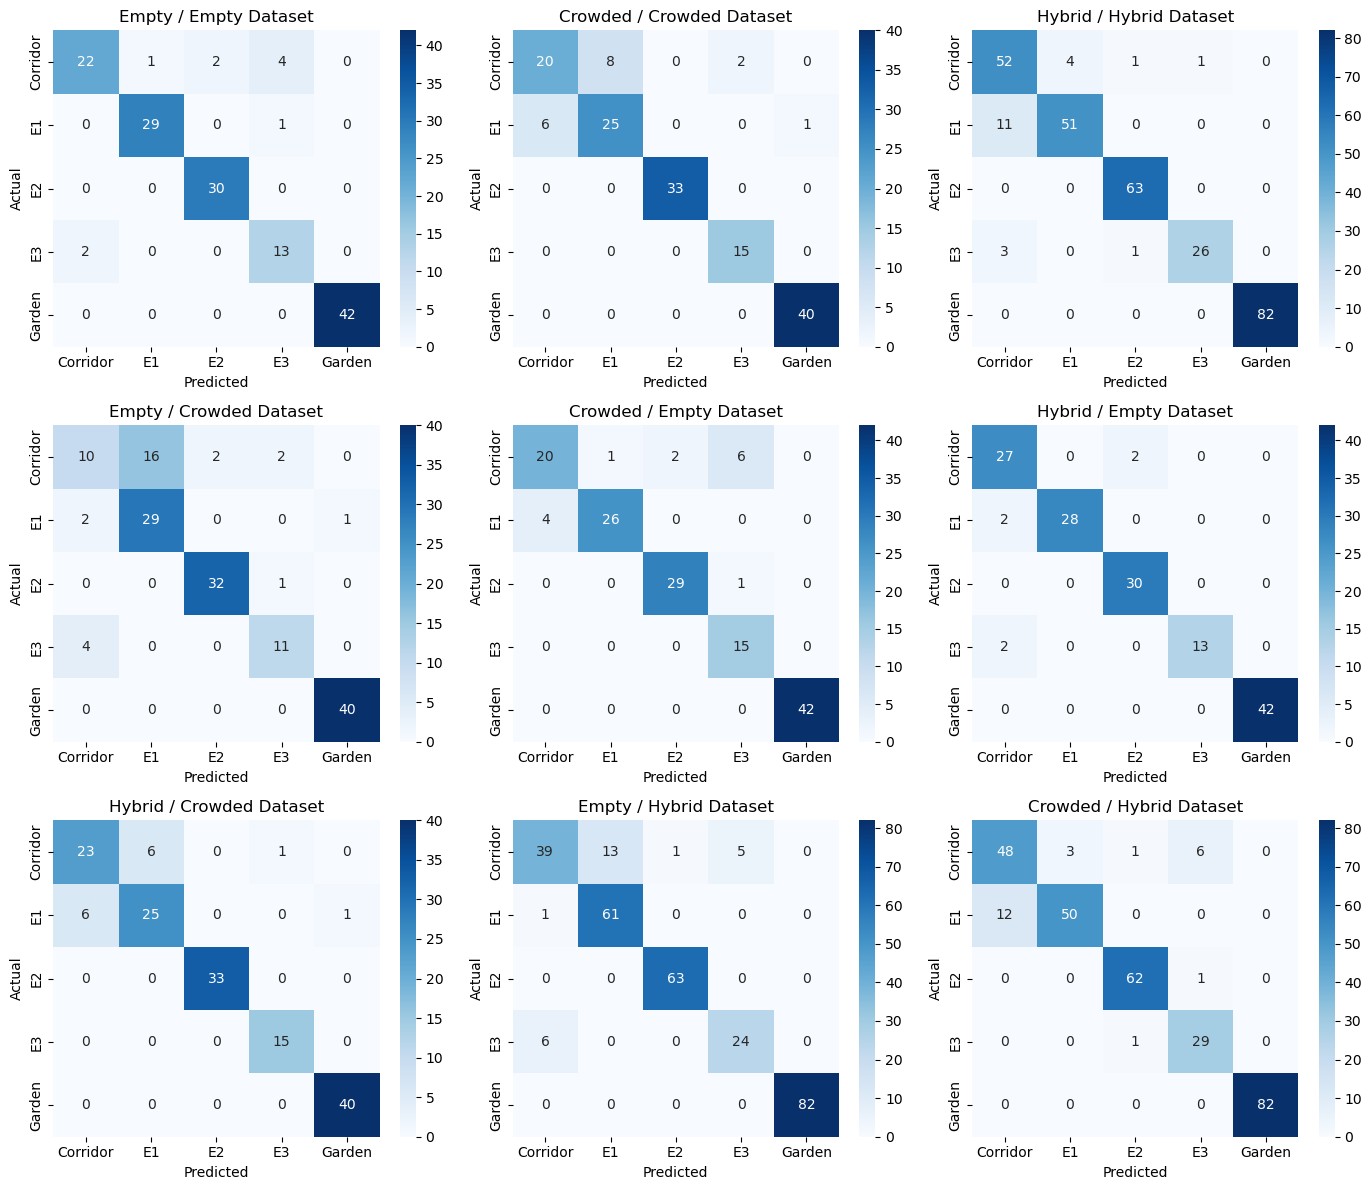

In [68]:
# Plot confusion matrices for the best models
def plot_conf_matrices():
    datasets = [
        (f"{em} / {em}", X_train_empty, y_train_empty, X_test_empty, y_test_empty, best_params_empty),
        (f"{cr} / {cr}", X_train_crowded, y_train_crowded, X_test_crowded, y_test_crowded, best_params_crowded),
        (f"{hy} / {hy}", X_train_hybrid, y_train_hybrid, X_test_hybrid, y_test_hybrid, best_params_hybrid),
        (f"{em} / {cr}",  X_train_empty, y_train_empty, X_test_crowded, y_test_crowded, best_params_empty),
        (f"{cr} / {em}", X_train_crowded, y_train_crowded, X_test_empty, y_test_empty, best_params_crowded),
        (f"{hy} / {em}", X_train_hybrid, y_train_hybrid, X_test_empty, y_test_empty, best_params_hybrid),
        (f"{hy} / {cr}", X_train_hybrid, y_train_hybrid, X_test_crowded, y_test_crowded, best_params_hybrid),
        (f"{em} / {hy}", X_train_empty, y_train_empty, X_test_hybrid, y_test_hybrid, best_params_empty),
        (f"{cr} / {hy}", X_train_crowded, y_train_crowded, X_test_hybrid, y_test_hybrid, best_params_crowded),
    ]

    num_plots = len(datasets)
    rows, cols = 3, 3
    fig, axes = plt.subplots(rows, cols, figsize=(14,12))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_plots:
            label, X_train, y_train, X_test, y_test, best_params = datasets[i]

            # Train the model with the best hyperparameters
            model = KNeighborsClassifier(**best_params)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Generate the confusion matrix
            cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

            # Plot confusion matrix
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), ax=ax)
            ax.set_title(f"{label} Dataset")
            ax.set_xlabel("Predicted")
            ax.set_ylabel("Actual")
        else:
            # Hide extra subplots if we have less than 9 datasets
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# Display the confusion matrices
print("\nConfusion matrices:")
plot_conf_matrices()